In [1]:
# create a sample target file
%%writefile gcd.cu

#include "gcd_utils.h"

int main() {
    printf("CUDA GCD Computation Program\n");
    printf("%s\n", SEPARATOR);

    // Initialize GPU
    int gpu_id = detect_and_set_gpu();
    print_gpu_info();

    // Initialize timing results
    TimingResults timing;

    // Generate two random numbers for single computation
    srand(time(NULL));
    int a = MIN_RANDOM + (rand() % (MAX_RANDOM - MIN_RANDOM + 1));
    int b = MIN_RANDOM + (rand() % (MAX_RANDOM - MIN_RANDOM + 1));

    printf("\n%s\n", SEPARATOR);
    printf("SINGLE GCD COMPUTATION\n");
    printf("%s\n", SEPARATOR);

    // Single GCD computation on GPU
    int *d_result;
    int h_result;

    check_cuda_error(cudaMalloc(&d_result, sizeof(int)), "Allocating device memory for single result");

    // Time single computation
    double start_time = get_time_ns();

    gcd_kernel_single<<<1, 1>>>(a, b, d_result);
    check_cuda_error(cudaDeviceSynchronize(), "Synchronizing after single kernel");

    double end_time = get_time_ns();
    timing.single_run_time_ns = end_time - start_time;

    check_cuda_error(cudaMemcpy(&h_result, d_result, sizeof(int), cudaMemcpyDeviceToHost),
                     "Copying single result to host");

    printf("Computing GCD(%d, %d) = %d\n", a, b, h_result);
    printf("Single computation time: %.2f nanoseconds\n", timing.single_run_time_ns);

    cudaFree(d_result);

    printf("\n%s\n", SEPARATOR);
    printf("BATCH GCD COMPUTATION (%d pairs)\n", N_PAIRS);
    printf("%s\n", SEPARATOR);

    // Batch GCD computation
    int *h_a_array, *h_b_array, *h_results;
    int *d_a_array, *d_b_array, *d_results;
    curandState *d_states;

    // Allocate host memory
    size_t array_size = N_PAIRS * sizeof(int);
    h_a_array = (int*)malloc(array_size);
    h_b_array = (int*)malloc(array_size);
    h_results = (int*)malloc(array_size);

    // Allocate device memory
    check_cuda_error(cudaMalloc(&d_a_array, array_size), "Allocating device memory for a_array");
    check_cuda_error(cudaMalloc(&d_b_array, array_size), "Allocating device memory for b_array");
    check_cuda_error(cudaMalloc(&d_results, array_size), "Allocating device memory for results");
    check_cuda_error(cudaMalloc(&d_states, N_PAIRS * sizeof(curandState)), "Allocating device memory for random states");

    // Calculate grid dimensions
    int blocks = (N_PAIRS + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;

    printf("Configuration:\n");
    printf("  Pairs to compute: %d\n", N_PAIRS);
    printf("  Threads per block: %d\n", THREADS_PER_BLOCK);
    printf("  Number of blocks: %d\n", blocks);
    printf("  Total threads: %d\n", blocks * THREADS_PER_BLOCK);

    // Setup random number generators
    printf("\nGenerating random number pairs...\n");
    setup_random_kernel<<<blocks, THREADS_PER_BLOCK>>>(d_states, time(NULL), N_PAIRS);
    check_cuda_error(cudaDeviceSynchronize(), "Synchronizing after random setup");

    generate_random_pairs<<<blocks, THREADS_PER_BLOCK>>>(d_states, d_a_array, d_b_array, N_PAIRS);
    check_cuda_error(cudaDeviceSynchronize(), "Synchronizing after random generation");

    // Time batch computation
    printf("Computing GCD for all pairs...\n");
    start_time = get_time_ns();

    gcd_kernel_batch<<<blocks, THREADS_PER_BLOCK>>>(d_a_array, d_b_array, d_results, N_PAIRS);
    check_cuda_error(cudaDeviceSynchronize(), "Synchronizing after batch kernel");

    end_time = get_time_ns();
    timing.batch_total_time_ns = end_time - start_time;
    timing.batch_average_time_ns = timing.batch_total_time_ns / N_PAIRS;

    // Copy results back to host
    check_cuda_error(cudaMemcpy(h_a_array, d_a_array, array_size, cudaMemcpyDeviceToHost),
                     "Copying a_array to host");
    check_cuda_error(cudaMemcpy(h_b_array, d_b_array, array_size, cudaMemcpyDeviceToHost),
                     "Copying b_array to host");
    check_cuda_error(cudaMemcpy(h_results, d_results, array_size, cudaMemcpyDeviceToHost),
                     "Copying results to host");

    printf("Batch computation completed!\n");

    // Show sample results
    printf("\nSample results (first 10 pairs):\n");
    for (int i = 0; i < 10 && i < N_PAIRS; i++) {
        printf("  GCD(%d, %d) = %d\n", h_a_array[i], h_b_array[i], h_results[i]);
    }

    // Verify a few results on CPU
    printf("\nVerification (checking first 5 results on CPU):\n");
    bool all_correct = true;
    for (int i = 0; i < 5 && i < N_PAIRS; i++) {
        int cpu_result = gcd_host(h_a_array[i], h_b_array[i]);
        bool correct = (cpu_result == h_results[i]);
        printf("  Pair %d: GPU=%d, CPU=%d %s\n", i+1, h_results[i], cpu_result,
               correct ? "✓" : "✗");
        if (!correct) all_correct = false;
    }
    printf("Verification: %s\n", all_correct ? "PASSED" : "FAILED");

    // Print final results
    print_timing_results(&timing, a, b, h_result);

    // Cleanup
    free(h_a_array);
    free(h_b_array);
    free(h_results);
    cudaFree(d_a_array);
    cudaFree(d_b_array);
    cudaFree(d_results);
    cudaFree(d_states);

    printf("\nProgram completed successfully!\n");
    return 0;
}


Writing gcd.cu


In [2]:
# let the target file be: file_of_interest = 'gcd.cu'
file_of_interest = 'gcd.cu'

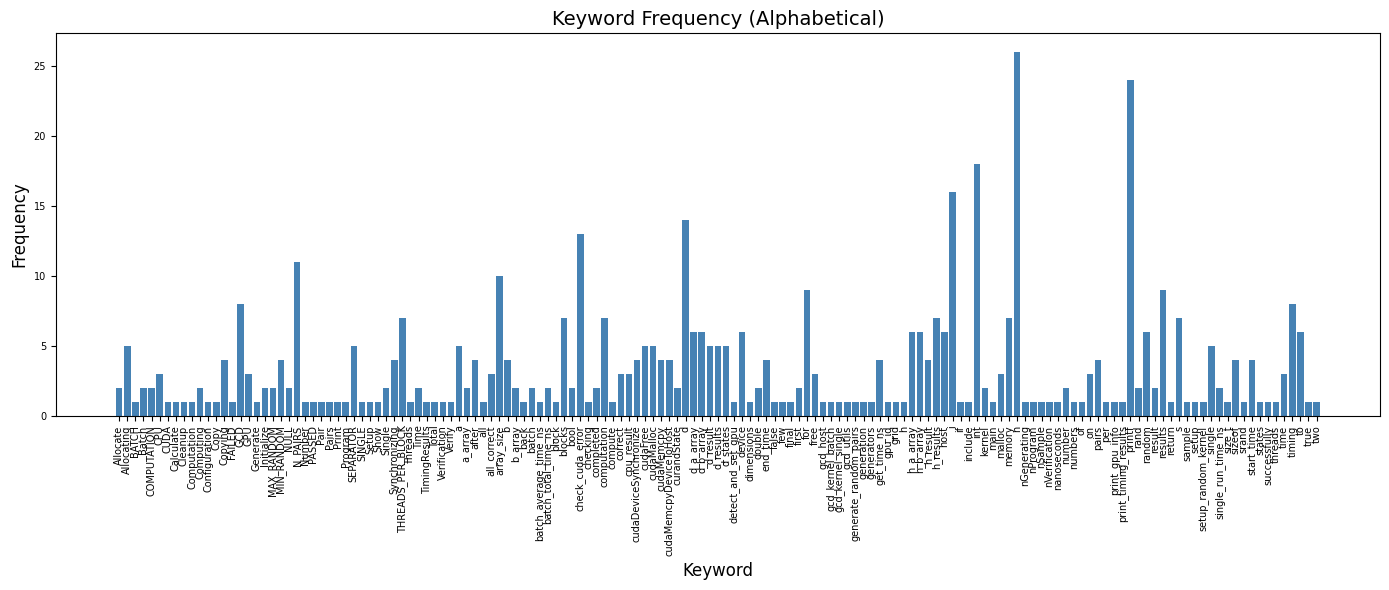

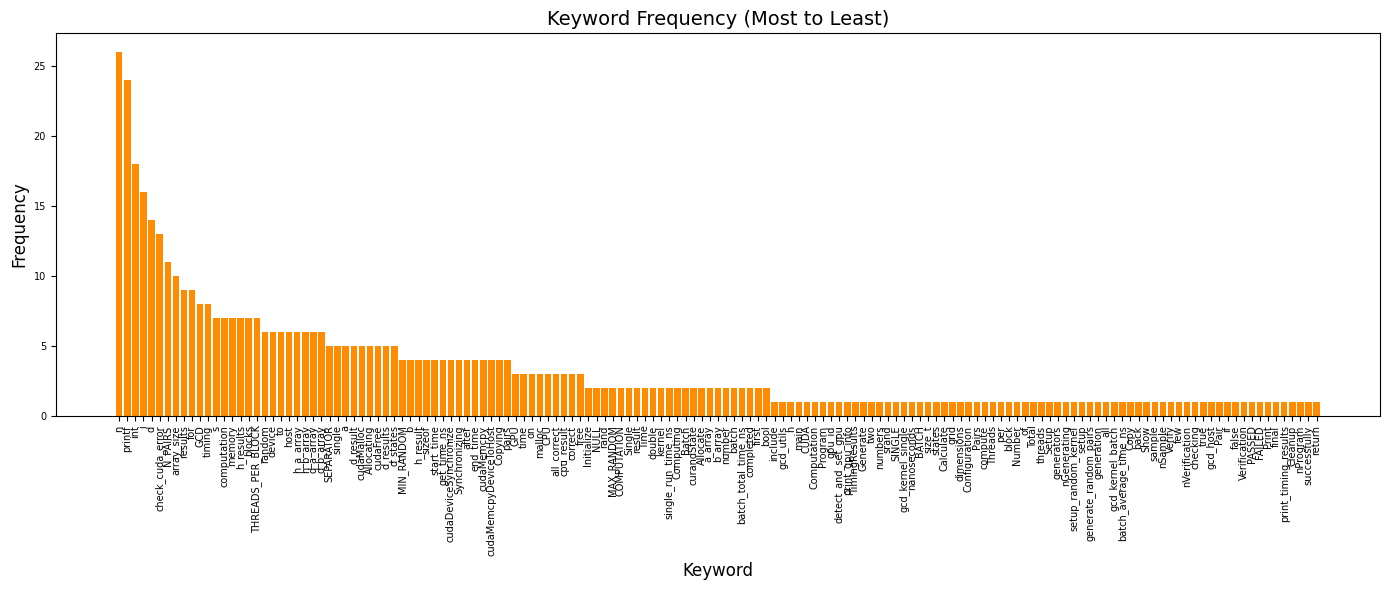

In [ ]:
# profile code
# tokenize_keywords_and_plot_histograms.py

import re
import matplotlib.pyplot as plt
from collections import Counter

# Read and tokenize unique words in a .cu file
def tokenize_keywords_and_plot_histograms(filename):
    with open(filename, 'r') as f:
        content = f.read()

    # Match only word tokens (excluding numbers, punctuation, etc.)
    tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', content)

    # Count word frequencies
    counter = Counter(tokens)

    # Sort by keyword (alphabetical)
    sorted_by_keyword = dict(sorted(counter.items()))
    # Sort by frequency (descending)
    sorted_by_frequency = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    # Font and color settings
    bar_color = 'steelblue'
    font_size = 7
    title_size = 14
    label_size = 12

     # Alphabetical plot
    plt.figure(figsize=(14, 6))
    plt.bar(sorted_by_keyword.keys(), sorted_by_keyword.values(), color=bar_color)
    plt.title('Keyword Frequency (Alphabetical)', fontsize=title_size)
    plt.xlabel('Keyword', fontsize=label_size)
    plt.ylabel('Frequency', fontsize=label_size)
    plt.xticks(rotation=90, fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.tight_layout()
    plt.show()

    # Frequency-based plot
    plt.figure(figsize=(14, 6))
    plt.bar(sorted_by_frequency.keys(), sorted_by_frequency.values(), color='darkorange')
    plt.title('Keyword Frequency (Most to Least)', fontsize=title_size)
    plt.xlabel('Keyword', fontsize=label_size)
    plt.ylabel('Frequency', fontsize=label_size)
    plt.xticks(rotation=90, fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    tokenize_keywords_and_plot_histograms(file_of_interest)


In [ ]:
# tokenize_keywords.py
import re

# Read and tokenize unique words in a .cu file
def tokenize_keywords(filename):
    with open(filename, 'r') as f:
        content = f.read()

    # Match only word tokens (excluding numbers, punctuation, etc.)
    tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', content)
    unique_tokens = sorted(set(tokens))

    print("Unique Keywords:")
    print(unique_tokens)
    print(f"Total unique keywords: {len(unique_tokens)}")

if __name__ == "__main__":
    tokenize_keywords(file_of_interest)

Unique Keywords:
['Allocate', 'Allocating', 'BATCH', 'Batch', 'COMPUTATION', 'CPU', 'CUDA', 'Calculate', 'Cleanup', 'Computation', 'Computing', 'Configuration', 'Copy', 'Copying', 'FAILED', 'GCD', 'GPU', 'Generate', 'Initialize', 'MAX_RANDOM', 'MIN_RANDOM', 'NULL', 'N_PAIRS', 'Number', 'PASSED', 'Pair', 'Pairs', 'Print', 'Program', 'SEPARATOR', 'SINGLE', 'Setup', 'Show', 'Single', 'Synchronizing', 'THREADS_PER_BLOCK', 'Threads', 'Time', 'TimingResults', 'Total', 'Verification', 'Verify', 'a', 'a_array', 'after', 'all', 'all_correct', 'array_size', 'b', 'b_array', 'back', 'batch', 'batch_average_time_ns', 'batch_total_time_ns', 'block', 'blocks', 'bool', 'check_cuda_error', 'checking', 'completed', 'computation', 'compute', 'correct', 'cpu_result', 'cudaDeviceSynchronize', 'cudaFree', 'cudaMalloc', 'cudaMemcpy', 'cudaMemcpyDeviceToHost', 'curandState', 'd', 'd_a_array', 'd_b_array', 'd_result', 'd_results', 'd_states', 'detect_and_set_gpu', 'device', 'dimensions', 'double', 'end_time', 

In [ ]:
# find where some of these keywords are
# keywords_locate.py

import re
from collections import defaultdict

# List of target keywords to track
keywords_to_track = [
    'printf', 'malloc', 'free', 'generate', 'write', 'file', 'time', 'state', 'main'
]

def track_keywords(filename, keywords):
    with open(filename, 'r') as f:
        lines = f.readlines()

    keyword_stats = {kw: {"total": 0, "lines": defaultdict(int)} for kw in keywords}

    for line_num, line in enumerate(lines, 1):
        # Skip string literals to avoid false positives
        line_wo_strings = re.sub(r'(\".*?\"|\'.*?\')', '', line)
        tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', line_wo_strings)

        for token in tokens:
            if token in keywords:
                keyword_stats[token]["total"] += 1
                keyword_stats[token]["lines"][line_num] += 1

    for kw in keywords:
        print(f"Keyword: '{kw}'")
        print(f"  Total occurrences: {keyword_stats[kw]['total']}")
        for line_num, count in sorted(keyword_stats[kw]['lines'].items()):
            print(f"    Line {line_num}: {count} occurrence(s)")
        print()

if __name__ == "__main__":
    track_keywords(file_of_interest, keywords_to_track)

Keyword: 'printf'
  Total occurrences: 24
    Line 5: 1 occurrence(s)
    Line 6: 1 occurrence(s)
    Line 20: 1 occurrence(s)
    Line 21: 1 occurrence(s)
    Line 22: 1 occurrence(s)
    Line 42: 1 occurrence(s)
    Line 43: 1 occurrence(s)
    Line 47: 1 occurrence(s)
    Line 48: 1 occurrence(s)
    Line 49: 1 occurrence(s)
    Line 71: 1 occurrence(s)
    Line 72: 1 occurrence(s)
    Line 73: 1 occurrence(s)
    Line 74: 1 occurrence(s)
    Line 75: 1 occurrence(s)
    Line 78: 1 occurrence(s)
    Line 86: 1 occurrence(s)
    Line 104: 1 occurrence(s)
    Line 107: 1 occurrence(s)
    Line 109: 1 occurrence(s)
    Line 113: 1 occurrence(s)
    Line 118: 1 occurrence(s)
    Line 122: 1 occurrence(s)
    Line 136: 1 occurrence(s)

Keyword: 'malloc'
  Total occurrences: 3
    Line 58: 1 occurrence(s)
    Line 59: 1 occurrence(s)
    Line 60: 1 occurrence(s)

Keyword: 'free'
  Total occurrences: 3
    Line 128: 1 occurrence(s)
    Line 129: 1 occurrence(s)
    Line 130: 1 occurrence(s

In [ ]:
# visual_tracing
# highlight_keywords.py

import re

# ANSI color codes
def color_wrap(word, color_code):
    return f"\033[{color_code}m{word}\033[0m"

def highlight_keywords(filename, keywords):
    with open(filename, 'r') as f:
        content = f.read()

    # Protect string literals from accidental highlighting
    string_literals = {}
    def protect_strings(match):
        key = f"__STR_{len(string_literals)}__"
        string_literals[key] = match.group(0)
        return key

    content_protected = re.sub(r'(["\'])(?:(?=(\\?))\2.)*?\1', protect_strings, content)

    # Assign a unique color to each keyword
    base_colors = ['31', '32', '33', '34', '35', '36', '91', '92', '93', '94']
    color_map = {kw: base_colors[i % len(base_colors)] for i, kw in enumerate(keywords)}

    # Highlight keywords
    for kw in keywords:
        pattern = rf'(?<![\w]){re.escape(kw)}(?![\w])'
        color = color_map[kw]
        content_protected = re.sub(pattern, lambda m: color_wrap(m.group(0), color), content_protected)

    # Restore string literals
    for key, value in string_literals.items():
        content_protected = content_protected.replace(key, value)

    # Print highlighted content
    print(content_protected)


if __name__ == "__main__":
    unique_keywords = [
        'printf',
        'sample',
        'get_time_ns',
        'print',
        'file'
    ]

    highlight_keywords(file_of_interest, unique_keywords)



#include "gcd_utils.h"

int main() {
    printf("CUDA GCD Computation Program\n");
    printf("%s\n", SEPARATOR);
    
    // Initialize GPU
    int gpu_id = detect_and_set_gpu();
    print_gpu_info();
    
    // Initialize timing results
    TimingResults timing;
    
    // Generate two random numbers for single computation
    srand(time(NULL));
    int a = MIN_RANDOM + (rand() % (MAX_RANDOM - MIN_RANDOM + 1));
    int b = MIN_RANDOM + (rand() % (MAX_RANDOM - MIN_RANDOM + 1));
    
    printf("\n%s\n", SEPARATOR);
    printf("SINGLE GCD COMPUTATION\n");
    printf("%s\n", SEPARATOR);
    
    // Single GCD computation on GPU
    int *d_result;
    int h_result;
    
    check_cuda_error(cudaMalloc(&d_result, sizeof(int)), "Allocating device memory for single result");
    
    // Time single computation
    double start_time = get_time_ns();
    
    gcd_kernel_single<<<1, 1>>>(a, b, d_result);
    check_cuda_error(cudaDeviceSynchronize(), "Synchronizing after single kernel");
   

In [ ]:
# replace_keywords.py

import re

def replace_keywords(filename, replacements):
    with open(filename, 'r') as f:
        content = f.read()

    # Skip string literals: extract them and preserve their position
    string_literals = {}
    def protect_strings(match):
        key = f"__STR_{len(string_literals)}__"
        string_literals[key] = match.group(0)
        return key

    # Temporarily remove string literals to avoid accidental replacement
    content_protected = re.sub(r'(["\'])(?:(?=(\\?))\2.)*?\1', protect_strings, content)

    # Replace variable and function names (identifiers)
    for original, new in replacements.items():
        pattern = rf'(?<![\w]){re.escape(original)}(?![\w])'  # strict word match only for identifiers
        content_protected = re.sub(pattern, new, content_protected)

    # Restore string literals
    for key, value in string_literals.items():
        content_protected = content_protected.replace(key, value)

    output_filename = filename + '.modified'
    with open(output_filename, 'w') as f:
        f.write(content_protected)

    print(f"Modified file written to: {output_filename}")


if __name__ == "__main__":
  # Add this to the top of the script
    unique_keywords = [
        'printf',
    ]

    unique_keywords_to_be_replaced_with = [
        '000111000111000',
    ]

    replacement_map = {
    original: replacement
    for original, replacement in zip(unique_keywords, unique_keywords_to_be_replaced_with)
    }

    replace_keywords(file_of_interest, replacement_map)


Modified file written to: gcd.cu.modified


In [4]:
# extract_cuda_symbols_full.py

import re

def extract_cuda_functions_and_variables(filename):
    with open(filename, 'r') as f:
        content = f.read()

    # Remove comments (// and /* */)
    content = re.sub(r'//.*?$|/\*.*?\*/', '', content, flags=re.MULTILINE | re.DOTALL)

    # --- Function name detection ---
    function_pattern = re.compile(
        r'\b(?:__\w+__\s+)?(?:[a-zA-Z_][a-zA-Z0-9_]*\s+)+([a-zA-Z_][a-zA-Z0-9_]*)\s*\([^;{]*\)\s*{'
    )
    function_names = set(function_pattern.findall(content))

    # --- Variable declaration block matching ---
    var_decl_pattern = re.compile(
        r'\b(?:int|float|double|char|bool|long|short|unsigned|size_t|curandState)\b([^;]+);'
    )
    variable_block_matches = var_decl_pattern.findall(content)

    # --- Extract individual variable names from each declaration ---
    variable_names = set()
    for block in variable_block_matches:
        # Split by commas, strip whitespace, extract names after optional pointer(s)
        vars_in_block = block.split(',')
        for var in vars_in_block:
            var = var.strip()
            # Extract variable name from something like "*ptr" or "***tensor"
            match = re.match(r'[\*\s]*([a-zA-Z_][a-zA-Z0-9_]*)', var)
            if match:
                variable_names.add(match.group(1))

    # Remove overlaps
    variable_names.difference_update(function_names)

    # Sort and print
    print("=== Function Names (Sorted) ===")
    for name in sorted(function_names):
        print(name)

    print("\n=== Variable Names (Sorted, including multiple pointers) ===")
    for name in sorted(variable_names):
        print(name)

if __name__ == "__main__":
    extract_cuda_functions_and_variables(file_of_interest)


=== Function Names (Sorted) ===
main

=== Variable Names (Sorted, including multiple pointers) ===
a
all_correct
array_size
b
blocks
correct
cpu_result
cudaMemcpyDeviceToHost
d_a_array
d_b_array
d_result
d_results
d_states
end_time
gpu_id
h_a_array
h_b_array
h_result
h_results
i
start_time


In [20]:
# extract_cuda_symbols_enhanced.py

import re

def extract_cuda_functions_and_variables(filename):
    with open(filename, 'r') as f:
        content = f.read()

    # Remove comments (// and /* */)
    content = re.sub(r'//.*?$|/\*.*?\*/', '', content, flags=re.MULTILINE | re.DOTALL)

    # --- Function name detection ---
    function_pattern = re.compile(
        r'\b(?:__\w+__\s+)?(?:[a-zA-Z_][a-zA-Z0-9_]*\s+)+([a-zA-Z_][a-zA-Z0-9_]*)\s*\([^;{]*\)\s*{'
    )
    function_names = set(function_pattern.findall(content))

    # --- Primitive and struct type definitions ---
    primitive_types = {
        'int', 'float', 'double', 'char', 'bool', 'long', 'short',
        'unsigned', 'signed', 'void', 'size_t', 'uint32_t', 'uint64_t'
    }

    # --- Variable declaration pattern (both primitive and struct types) ---
    var_decl_pattern = re.compile(
        r'\b([a-zA-Z_][a-zA-Z0-9_]*)\s+([^;]+);'
    )
    variable_block_matches = var_decl_pattern.findall(content)

    # --- Separate collections ---
    primitive_variables = set()
    primitive_pointers = set()
    struct_variables = set()
    struct_pointers = set()

    # --- Process each variable declaration ---
    for type_name, block in variable_block_matches:
        # Skip if it looks like a function declaration
        if '(' in block:
            continue

        # Split by commas to handle multiple variables in one declaration
        vars_in_block = block.split(',')

        for var in vars_in_block:
            var = var.strip()
            # Count asterisks and extract variable name
            asterisk_match = re.match(r'(\**)([a-zA-Z_][a-zA-Z0-9_]*)', var)
            if asterisk_match:
                asterisks, var_name = asterisk_match.groups()
                is_pointer = len(asterisks) > 0

                # Categorize based on type and pointer status
                if type_name in primitive_types:
                    if is_pointer:
                        primitive_pointers.add(var_name)
                    else:
                        primitive_variables.add(var_name)
                else:
                    # Assume it's a struct/custom type
                    if is_pointer:
                        struct_pointers.add(var_name)
                    else:
                        struct_variables.add(var_name)

    # Remove function names from all variable sets
    primitive_variables.difference_update(function_names)
    primitive_pointers.difference_update(function_names)
    struct_variables.difference_update(function_names)
    struct_pointers.difference_update(function_names)

    # --- Print results ---
    print("=== Function Names ===")
    for name in sorted(function_names):
        print(name)

    print("\n=== Primitive Variables ===")
    for name in sorted(primitive_variables):
        print(name)

    print("\n=== Primitive Pointer Variables ===")
    for name in sorted(primitive_pointers):
        print(name)

    print("\n=== Struct/Custom Type Variables ===")
    for name in sorted(struct_variables):
        print(name)

    print("\n=== Struct/Custom Type Pointer Variables ===")
    for name in sorted(struct_pointers):
        print(name)

if __name__ == "__main__":
    # Change this to your actual filename
    filename = file_of_interest
    extract_cuda_functions_and_variables(filename)

=== Function Names ===
main

=== Primitive Variables ===
all_correct
h_result

=== Primitive Pointer Variables ===
d_a_array
d_b_array
d_result
d_results
h_a_array
h_b_array
h_results

=== Struct/Custom Type Variables ===
CPU
GCD
N_PAIRS
THREADS_PER_BLOCK
a_array
after
b_array
blocks
completed
computation
correct
cpu_result
device
h_results
i
of
per
random
results
single
threads
timing
to

=== Struct/Custom Type Pointer Variables ===
d_states
